In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('/home/ajay/Python For Time Series Analysis/Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)

ModuleNotFoundError: No module named 'google'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.index.freq = 'MS'

In [5]:
df.columns = ['Sales']

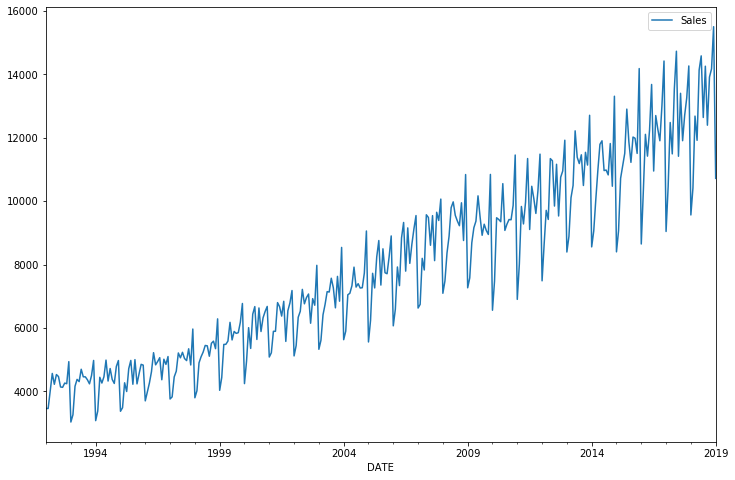

In [6]:
df.plot(figsize=(12,8))

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
results = seasonal_decompose(df['Sales'])

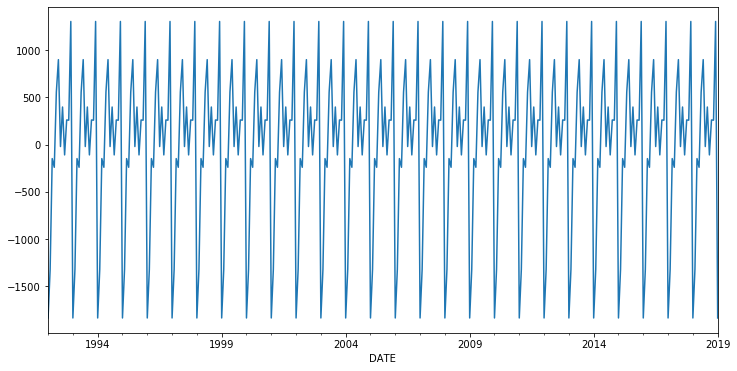

In [22]:
results.seasonal.plot(figsize=(12,6));

In [23]:
len(df)

325

In [24]:
325-12

313

In [25]:
train = df.iloc[:313]
test = df.iloc[313:]

In [26]:
len(test)

12

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
scaler = MinMaxScaler()

In [30]:
scaler.fit(train) # finds the max value in the training dataset

MinMaxScaler(copy=True, feature_range=(0, 1))

In [34]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [35]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [47]:
# if it has seasonality thake the input which covers seasonality
n_input = 12
n_features = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [48]:
len(scaled_train)

313

In [49]:
len(generator)

301

In [50]:
X,y = generator[0]

In [51]:
X

array([[[0.03658432],
        [0.03649885],
        [0.08299855],
        [0.13103684],
        [0.1017181 ],
        [0.12804513],
        [0.12266006],
        [0.09453799],
        [0.09359774],
        [0.10496624],
        [0.10334217],
        [0.16283443]]])

In [52]:
y

array([[0.]])

In [53]:
X.shape

(1, 12, 1)

In [54]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [55]:
model = Sequential()

model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='Adam')

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.fit_generator(generator,epochs=25)

Epoch 1/25
301/301 [==============================] - 7s 22ms/step - loss: 0.0199
Epoch 2/25
301/301 [==============================] - 6s 19ms/step - loss: 0.0099
Epoch 3/25
301/301 [==============================] - 6s 19ms/step - loss: 0.0090
Epoch 4/25
301/301 [==============================] - 5s 18ms/step - loss: 0.0084
Epoch 5/25
301/301 [==============================] - 6s 18ms/step - loss: 0.0070
Epoch 6/25
301/301 [==============================] - 5s 18ms/step - loss: 0.0053
Epoch 7/25
301/301 [==============================] - 5s 18ms/step - loss: 0.0038
Epoch 8/25
301/301 [==============================] - 5s 17ms/step - loss: 0.0036
Epoch 9/25
301/301 [==============================] - 6s 19ms/step - loss: 0.0030
Epoch 10/25
301/301 [==============================] - 5s 18ms/step - loss: 0.0025
Epoch 11/25
301/301 [==============================] - 5s 18ms/step - loss: 0.0022
Epoch 12/25
301/301 [==============================] - 5s 18ms/step - loss: 0.0026
Epoch 13/25
3

In [58]:
model.history.history.keys()

dict_keys(['loss'])

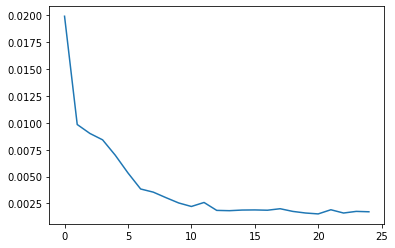

In [60]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss'])

In [61]:
# 12 history ---> step13
# Need last 12 points to predict 13 points

In [62]:
first_eval_batch = scaled_train[-12:]

In [65]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [66]:
model.predict(first_eval_batch)

array([[0.7034823]], dtype=float32)

## Forecast Using RNN Model

In [85]:
#holding my predictions
test_pred = []

#last n input points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test+1)):
    current_pred = model.predict(current_batch)[0]    
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [86]:
test_pred

[array([0.7034823], dtype=float32),
 array([0.82767564], dtype=float32),
 array([0.78256536], dtype=float32),
 array([0.9425088], dtype=float32),
 array([1.0154675], dtype=float32),
 array([0.7727781], dtype=float32),
 array([0.91245073], dtype=float32),
 array([0.78862184], dtype=float32),
 array([0.8605418], dtype=float32),
 array([0.90900844], dtype=float32),
 array([0.97727233], dtype=float32),
 array([0.6216974], dtype=float32)]

In [87]:
true_pred = scaler.inverse_transform(test_pred)

In [88]:
true_pred

array([[11261.03907955],
       [12713.97731918],
       [12186.23209167],
       [14057.4106468 ],
       [14910.95456946],
       [12071.73091954],
       [13705.76109964],
       [12257.08693963],
       [13098.47875834],
       [13665.48977882],
       [14464.10900873],
       [10304.23818493]])

In [89]:
test['Predictions'] = true_pred

/usr/local/pytorch-py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


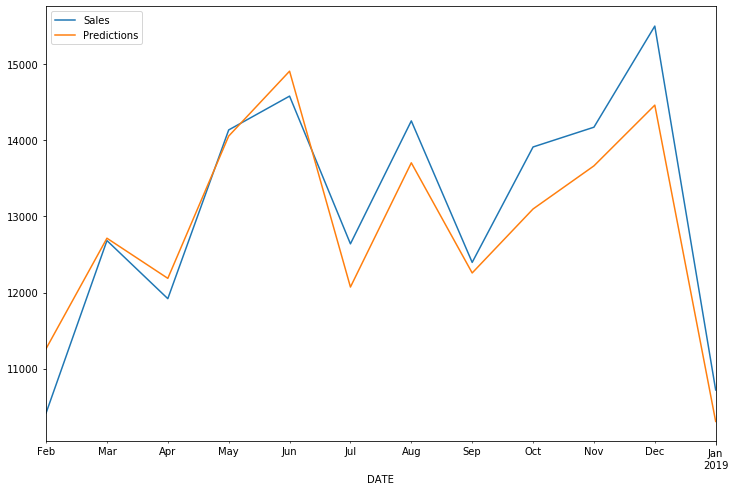

In [90]:
test.plot(figsize=(12,8))

In [91]:
model.save('/home/ajay/Python For Time Series Analysis/Models/alchoal_prediction.h5')

In [92]:
from keras.models import load_model

In [93]:
new_model = load_model('/home/ajay/Python For Time Series Analysis/Models/alchoal_prediction.h5')

In [94]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [1]:
!pwd

/home/ajay/Python For Time Series Analysis
